In [115]:
import os
import sys
import pickle
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.models import jacobian_aln as jac_aln
import neurolib.dashboard.data as data

In [21]:
data_file = '..' + os.sep + 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]

bestControl = [None] * len(exc)
bestState = [None] * len(exc)

i_range = np.arange(0,83,1)

read_file = '..' + os.sep + 'data_final_2' + os.sep + 'control_2.pickle'
    
with open(read_file,'rb') as f:
    load_array = pickle.load(f)

bestControl = load_array[0]
bestState = load_array[1]

In [31]:
aln = ALNModel()

dt = aln.params.dt

ext_exc_current = aln.params.ext_exc_current
ext_inh_current = aln.params.ext_inh_current

# ee, ei, ie, ii
ext_ee_rate = aln.params.ext_ee_rate
ext_ei_rate = aln.params.ext_ei_rate
ext_ie_rate = aln.params.ext_ie_rate
ext_ii_rate = aln.params.ext_ii_rate

sigmae_ext = aln.params.sigmae_ext
sigmai_ext = aln.params.sigmai_ext

a = aln.params["a"]
b = aln.params["b"]
tauA = aln.params["tauA"]

C = aln.params["C"]
c_gl = aln.params["c_gl"]
Ke_gl = aln.params["Ke_gl"]
Ki_gl = aln.params["Ki_gl"]

Ke = aln.params["Ke"]
Ki = aln.params["Ki"]
tau_se = aln.params["tau_se"] 
tau_si = aln.params["tau_si"] 
cee = aln.params["cee"]
cei = aln.params["cei"]
cie = aln.params["cie"]
cii = aln.params["cii"]
Jee_max = aln.params["Jee_max"]
Jei_max = aln.params["Jei_max"]
Jie_max = aln.params["Jie_max"]
Jii_max = aln.params["Jii_max"]
taum = aln.params.C / aln.params.gL

tau_se_sq = tau_se**2
tau_si_sq = tau_si**2
Jee_sq = Jee_max**2
Jei_sq = Jei_max**2
Jie_sq = Jie_max**2
Jii_sq = Jii_max**2

tau_ou = aln.params.tau_ou

N = aln.params.N
V = len(aln.state_vars)

ndt_de = np.around(aln.params.de / dt).astype(int)
ndt_di = np.around(aln.params.di / dt).astype(int)

factor_ee1 = ( cee * Ke * tau_se / np.abs(Jee_max) )
factor_ee2 = ( cee**2 * Ke * tau_se_sq / Jee_sq )

factor_ei1 = ( cei * Ki * tau_si / np.abs(Jei_max) )
factor_ei2 = ( cei**2 * Ki * tau_si_sq / Jei_sq )

factor_ie1 = ( cie * Ke * tau_se / np.abs(Jie_max) )
factor_ie2 = ( cie**2 * Ke * tau_se_sq / Jie_sq )

factor_ii1 = ( cii * Ki * tau_si / np.abs(Jii_max) )
factor_ii2 = ( cii**2 * Ki * tau_si_sq / Jii_sq )

factor_eec1 = c_gl * Ke_gl * tau_se / np.abs(Jee_max)
factor_eec2 = c_gl**2 * Ke_gl * tau_se_sq / Jee_sq 

factor_eic1 = c_gl * Ki_gl * tau_si / np.abs(Jei_max)
factor_eic2 = c_gl**2 * Ki_gl * tau_si_sq / Jei_sq 

factor_iec1 = c_gl * Ke_gl * tau_se / np.abs(Jie_max)
factor_iec2 = c_gl**2 * Ke_gl * tau_se_sq / Jie_sq 

factor_iic1 = c_gl * Ki_gl * tau_si / np.abs(Jii_max)
factor_iic2 = c_gl**2 * Ki_gl * tau_si_sq / Jii_sq 

sigmarange = aln.params["sigmarange"]
ds = aln.params["ds"]
Irange = aln.params["Irange"]
dI = aln.params["dI"]
precalc_r = aln.params["precalc_r"]
precalc_tau_mu = aln.params["precalc_tau_mu"]
precalc_V = aln.params["precalc_V"]

shift_e = np.around(aln.params.de / dt).astype(int)
shift_i = np.around(aln.params.di / dt).astype(int)

20


In [46]:
def jacobian(V, state_, state_pre_):
    
    jacobian_ = np.zeros(( V, V ))
    
    z1ee = factor_ee1 * state_pre_[0,-shift_e-1] * 1e-3 + factor_eec1 * ( ext_ee_rate )
    z2ee = factor_ee2 * state_pre_[0,-shift_e-1] * 1e-3 + factor_eec2 * ( ext_ee_rate )
    z1ie = factor_ie1 * state_pre_[0,-shift_e-1] * 1e-3 + factor_iec1 * ( ext_ie_rate )
    z2ie = factor_ie2 * state_pre_[0,-shift_e-1] * 1e-3 + factor_iec2 * ( ext_ie_rate )

    z1ei = factor_ei1 * state_pre_[1,-shift_i-1] * 1e-3 + factor_eic1 * (  ext_ei_rate )
    z2ei = factor_ei2 * state_pre_[1,-shift_i-1] * 1e-3 + factor_eic2 * ( ext_ei_rate )         
    z1ii = factor_ii1 * state_pre_[1,-shift_i-1] * 1e-3 + factor_iic1 * ( ext_ii_rate )
    z2ii = factor_ii2 * state_pre_[1,-shift_i-1] * 1e-3 + factor_iic2 * ( ext_ii_rate )

    jacobian_[0,2] = - d_r_func_mu(state_[2] - state_[4]/C, sigmarange, ds,
                                      state_[15], Irange, dI, C, precalc_r) * 1e3
    jacobian_[0,4] = d_r_func_mu(state_[2] - state_[4]/C, sigmarange, ds,
                                      state_[15], Irange, dI, C, precalc_r) * 1e3 / C
    jacobian_[0,15] = - d_r_func_sigma(state_[2] - state_[4]/C, sigmarange, ds,
                                          state_[15], Irange, dI, C, precalc_r) * 1e3

    jacobian_[1,3] = - d_r_func_mu(state_[3], sigmarange, ds,
                                      state_[16], Irange, dI, C, precalc_r) * 1e3
    jacobian_[1,16] = - d_r_func_sigma(state_[3], sigmarange, ds,
                                          state_[16], Irange, dI, C, precalc_r) * 1e3

    jacobian_[2,2] = 1. / state_[18]
    jacobian_[2,5] = - Jee_max / state_[18]
    jacobian_[2,6] = - Jei_max / state_[18]

    jacobian_[2,18] = ( Jee_max * state_[5] + Jei_max * state_[6] + ext_exc_current
                       + state_[13] - state_[2] ) / state_[18]**2

    jacobian_[3,3] = 1. / state_[19]
    jacobian_[3,7] = - Jie_max / state_[19]
    jacobian_[3,8] = - Jii_max / state_[19]
    jacobian_[3,19] = ( Jie_max * state_[7] + Jii_max * state_[8] + ext_inh_current
                   + state_[14] - state_[3] ) / state_[19]**2

    jacobian_[4,0] = - b * 1e-3
    jacobian_[4,4] = 1. / tauA
    jacobian_[4,17] = - a / tauA

    jacobian_[5,0] = - factor_ee1 * 1e-3 * ( 1. - state_[5] ) / tau_se
    jacobian_[5,5] = ( 1. + z1ee ) / tau_se

    jacobian_[6,1] = - factor_ei1 * 1e-3 * ( 1. - state_[6] ) / tau_si
    jacobian_[6,6] = ( 1. + z1ei ) / tau_si

    jacobian_[7,0] = - factor_ie1 * 1e-3 * ( 1. - state_[7] ) / tau_se
    jacobian_[7,7] = ( 1. + z1ie ) / tau_se

    jacobian_[8,1] = - factor_ii1 * 1e-3 * ( 1. - state_[8] ) / tau_si
    jacobian_[8,8] = ( 1. + z1ii ) / tau_si

    jacobian_[9,0] = ( - ( 1. - state_[5] )**2 * factor_ee2 * 1e-3
                         - ( factor_ee2 - 2. * tau_se * factor_ee1 ) * 1e-3 * state_[9] ) / tau_se_sq
    jacobian_[9,5] = 2. * ( 1. - state_[5] ) * z2ee / tau_se_sq
    jacobian_[9,9] = - ( z2ee - 2. * tau_se * ( z1ee + 1 ) ) / tau_se_sq

    jacobian_[10,1] = ( - ( 1. - state_[6] )**2 * factor_ei2 * 1e-3
                         - ( factor_ei2 - 2. * tau_si * factor_ei1 ) * 1e-3 * state_[10] ) / tau_si_sq
    jacobian_[10,6] = 2. * ( 1. - state_[6] ) * z2ei / tau_si_sq
    jacobian_[10,10] = - ( z2ei - 2. * tau_si * ( z1ei + 1 ) ) / tau_si_sq

    jacobian_[11,0] = ( - ( 1. - state_[7] )**2 * factor_ie2 * 1e-3
                          - ( factor_ie2 - 2. * tau_se * factor_ie1 ) * 1e-3 * state_[11] ) / tau_se_sq
    jacobian_[11,7] = 2. * ( 1. - state_[7] ) * z2ie / tau_se_sq
    jacobian_[11,11] = - ( z2ie - 2. * tau_se * ( z1ie + 1 ) ) / tau_se_sq

    jacobian_[12,1] = ( - ( 1. - state_[8] )**2 * factor_ii2 * 1e-3
                         - ( factor_ii2 - 2. * tau_si * factor_ii1 ) * 1e-3 * state_[12]) / tau_si_sq
    jacobian_[12,8] = 2. * ( 1. - state_[8] ) * z2ii / tau_si_sq
    jacobian_[12,12] = - ( z2ii - 2. * tau_si * ( z1ii + 1 ) ) / tau_si_sq

    sigma_ee = 2. * Jee_sq * state_[9] * tau_se * taum / ((1. + z1ee) * taum + tau_se)
    sigma_ei = 2. * Jei_sq * state_[10] * tau_si * taum * ( (1. + z1ei ) * taum + tau_si )**(-1)

    arg = ( sigma_ee + sigma_ei + sigmae_ext**2 )
    if arg > 0:
        sigma_sqrt_e = arg**(-1./2.)
    else:
        sigma_sqrt_e = 0.
        #print("WARNING: sigma e smaller zero")

    jacobian_[15,0] = ( 0.5 * ( (1. + z1ee) * taum + tau_se )**(-2.) * factor_ee1 * 1e-3 * taum
                          * ( 2. * Jee_sq * tau_se * taum * state_[9] ) * sigma_sqrt_e )
    jacobian_[15,1] = ( 0.5 * ( (1. + z1ei) * taum + tau_si )**(-2.) * factor_ei1 * 1e-3 * taum
                          * ( 2. * Jei_sq * tau_si * taum * state_[10] ) * sigma_sqrt_e )
    jacobian_[15,9] = - 0.5 * 2. * Jee_sq * tau_se * taum * ( (1. + z1ee) * taum + tau_se )**(-1.) * sigma_sqrt_e
    jacobian_[15,10] = - 0.5 * 2. * Jei_sq * tau_si * taum * ( (1. + z1ei) * taum + tau_si )**(-1.) * sigma_sqrt_e

    sigma_ie = 2. * Jie_sq * state_[11] * tau_se * taum / ((1. + z1ie) * taum + tau_se)
    sigma_ii = 2. * Jii_sq * state_[12] * tau_si * taum * ( (1. + z1ii ) * taum + tau_si )**(-1)

    arg = ( sigma_ie + sigma_ii + sigmai_ext**2 )
    if arg > 0:
        sigma_sqrt_i = arg**(-1./2.)
    else:
        sigma_sqrt_i = 0.
        print("WARNING: sigma i smaller zero")

    jacobian_[16,0] = ( 0.5 * ( (1. + z1ie) * taum + tau_se )**(-2.) * factor_ie1 * 1e-3 * taum
                          * ( 2. * Jie_sq * tau_se * taum * state_[11] ) * sigma_sqrt_i )
    jacobian_[16,1] = ( 0.5 * ( (1. + z1ii) * taum + tau_si )**(-2.) * factor_ii1 * 1e-3 * taum
                          * ( 2. * Jii_sq * tau_si * taum * state_[12] ) * sigma_sqrt_i )
    jacobian_[16,11] = - 0.5 * 2. * Jie_sq * tau_se * taum * ( (1. + z1ie) * taum + tau_se )**(-1.) * sigma_sqrt_i
    jacobian_[16,12] = - 0.5 * 2. * Jii_sq * tau_si * taum * ( (1. + z1ii) * taum + tau_si )**(-1.) * sigma_sqrt_i

    jacobian_[17,2] = - d_V_func_mu(state_[2] - state_[4]/C, sigmarange, ds,
                                      state_[15], Irange, dI, C, precalc_V)
    jacobian_[17,4] = d_V_func_mu(state_[2] - state_[4]/C, sigmarange, ds,
                                      state_[15], Irange, dI, C, precalc_V) / C
    jacobian_[17,15] = - d_V_func_sigma(state_[2] - state_[4]/C, sigmarange, ds,
                                      state_[15], Irange, dI, C, precalc_V)

    jacobian_[18,2] = - d_tau_func_mu(state_[2] - state_[4]/C, sigmarange, ds,
                                      state_[15], Irange, dI, C, precalc_tau_mu)
    jacobian_[18,4] = d_tau_func_mu(state_[2] - state_[4]/C, sigmarange, ds,
                                      state_[15], Irange, dI, C, precalc_tau_mu) / C
    jacobian_[18,15] = - d_tau_func_sigma(state_[2] - state_[4]/C, sigmarange, ds,
                                      state_[15], Irange, dI, C, precalc_tau_mu)

    jacobian_[19,3] = - d_tau_func_mu(state_[3], sigmarange, ds,
                                      state_[16], Irange, dI, C, precalc_tau_mu)
    jacobian_[19,16] = - d_tau_func_sigma(state_[3], sigmarange, ds,
                                      state_[16], Irange, dI, C, precalc_tau_mu)

    
    return jacobian_

In [48]:
def d_r_func_mu(mu, sigmarange, ds, sigma, Irange, dI, C, precalc_r):
    result = jac_aln.der_mu(sigma, sigmarange, ds, mu, Irange, dI, C, precalc_r)
    return result

def d_r_func_sigma(mu, sigmarange, ds, sigma, Irange, dI, C, precalc_r):
    result = jac_aln.der_sigma(sigma, sigmarange, ds, mu, Irange, dI, C, precalc_r)
    return result

def d_tau_func_mu(mu, sigmarange, ds, sigma, Irange, dI, C, precalc_tau_mu):
    result = jac_aln.der_mu(sigma, sigmarange, ds, mu, Irange, dI, C, precalc_tau_mu)
    return result

def d_tau_func_sigma(mu, sigmarange, ds, sigma, Irange, dI, C, precalc_tau_mu):
    result = jac_aln.der_sigma(sigma, sigmarange, ds, mu, Irange, dI, C, precalc_tau_mu)
    return result

def d_V_func_mu(mu, sigmarange, ds, sigma, Irange, dI, C, precalc_V):
    result = jac_aln.der_mu(sigma, sigmarange, ds, mu, Irange, dI, C, precalc_V)
    return result

def d_V_func_sigma(mu, sigmarange, ds, sigma, Irange, dI, C, precalc_V):
    result = jac_aln.der_sigma(sigma, sigmarange, ds, mu, Irange, dI, C, precalc_V)
    return result

In [109]:
i = 20
t_ = 3000
prestate = bestState[i][0,:,t_-41:t_]
state_t = bestState[i][0,:,t_]
state_t0 = bestState[i][0,:,100]
state_t0 = np.delete(state_t0, [13,14], 0)
tauE = state_t[18]
tauI = state_t[19]

A = jacobian(V, state_t, prestate)
print(A.shape)
#A = np.delete(A, [0,1,4,13,14,15,16,17,18,19], 0)
#A = np.delete(A, [0,1,4,13,14,15,16,17,18,19], 1)
A = np.delete(A, [13,14], 0)
A = np.delete(A, [13,14], 1)
print(A.shape)
np.linalg.inv(A)

V_ = 18
T = 5000

B = np.zeros((V_, V_))
B[2,0] = 1./tauE
B[3,1] = 1./tauI

(20, 20)
(18, 18)


In [97]:
data.set_parameters(aln)
aln.params.duration = 3000.

aln.params.ext_exc_current = exc[i] * 5.
aln.params.ext_inh_current = inh[i] * 5.

control0 = aln.getZeroControl()
control0[0,0,:500] = 5.
aln.run(control=control0)

state_final = np.zeros((V))
for v_ in range(V):
    state_final[v_] = aln.state[aln.state_vars[v_]][0,-1]

state_final = np.delete(state_final, [13,14], 0)
print(state_final)

[ 3.56907060e+01  9.03982158e+01  1.30267746e+00  3.04982338e+00
  0.00000000e+00  8.75776644e-01  9.31957511e-01  8.68231261e-01
  9.64986524e-01  8.81904176e-04  3.51707169e-04  9.15578894e-04
  2.11441669e-04  1.50170515e+00  1.50113863e+00 -5.66690663e+01
  1.59839325e+00  4.71000000e-01]


In [133]:
A_tilde = np.zeros(( 2*V_, 2*V_ ))
A_tilde[:V_,:V_] = A
A_tilde[:V_, V_:] = -2. * np.matmul(B, np.transpose(B))
A_tilde[V_,0] = - 2.
A_tilde[V_+1,1] = - 2.
A_tilde[V_:,V_:] = - np.transpose(A)

np.linalg.inv(A)

b_tilde = np.zeros((2*V_))
# if t > 4900
b_tilde[V_] = 2. * target_[0,0,-1]
b_tilde[V_+1] = 2. * target_[0,1,-1]

b_tt = np.matmul(np.linalg.inv(A_tilde), b_tilde)
EAT = scipy.linalg.expm(A_tilde * 2.)

E11 = EAT[:V_,:V_]
E12 = EAT[:V_,V_:]
E21 = EAT[V_:,:V_]
E22 = EAT[V_:,V_:]

c_tilde1 = state_t0 + b_tt[:V_]
lambdaT = np.matmul( np.linalg.inv(E12), (c_tilde1
                        - np.matmul(E11, b_tt[:V_]) - np.matmul(E12, b_tt[V_:]) - np.matmul(E22, b_tt[V_:])) )

c_tilde2 = np.matmul(E21, state_final) + np.matmul(E22, lambdaT) + np.matmul(E21, b_tt[:V_]) + np.matmul(E22, b_tt[V_:])
c_tilde = np.zeros(2*V_)
c_tilde[:V_] = c_tilde1
c_tilde[V_:] = c_tilde2

m2 = np.matmul(np.linalg.inv(A_tilde), b_tilde)

x_tilde = np.zeros(( 2*V_, T ))
for t_ind in range(T):
    print(t_ind)
    m1 = np.matmul(scipy.linalg.expm(A_tilde * t_ind * dt), c_tilde)
    print(np.amax(m1), np.amax(m2))
    x_tilde[:,t_ind] = np.matmul(scipy.linalg.expm(A_tilde * t_ind * dt),
                            c_tilde) - np.matmul(np.linalg.inv(A_tilde), b_tilde)
    if t_ind == 20:
        break

0
4.065160083312921e+23 4382154.583004076
1
4.0486438838391446e+23 4382154.583004076
2
4.0349045664324986e+23 4382154.583004076
3
4.023476298572202e+23 4382154.583004076
4
4.013971393043206e+23 4382154.583004076
5
4.006067198956459e+23 4382154.583004076
6
3.999495191847014e+23 4382154.583004076
7
3.99403189366786e+23 4382154.583004076
8
3.9894913151561975e+23 4382154.583004076
9
3.98571866449307e+23 4382154.583004076
10
3.982585109640605e+23 4382154.583004076
11
3.9799834194160356e+23 4382154.583004076
12
3.977824341988915e+23 4382154.583004076
13
3.976033609124186e+23 4382154.583004076
14
3.974549476298049e+23 4382154.583004076
15
3.973320712728395e+23 4382154.583004076
16
3.972304925805617e+23 4382154.583004076
17
3.9714670303702526e+23 4382154.583004076
18
3.970777576210286e+23 4382154.583004076
19
3.970210629885899e+23 4382154.583004076
20
3.969741204638805e+23 4382154.583004076


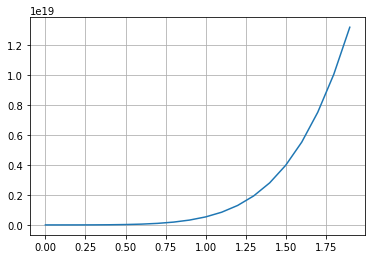

In [135]:
time_ = np.arange(0,2,dt)
plt.plot(time_, x_tilde[0,:20])
plt.show()